In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pulp

In [17]:

def nearest_market_strike(strike, calls, puts, option_type=None):
    """
    Finds the nearest available market strike for calls/puts dataframes.
    """
    if option_type == 'call':
        relevant_options = calls.assign(option_type='call', sign=+1)
    elif option_type == 'put':
        relevant_options = puts.assign(option_type='put', sign=-1)
    else:  # combine both
        relevant_options = pd.concat([
            calls.assign(option_type='call', sign=+1),
            puts.assign(option_type='put', sign=-1)
        ], ignore_index=True)

    count = len(relevant_options)
    relevant_options['strike_diff'] = abs(relevant_options['strike'] - strike)
    nearest_option = relevant_options.loc[relevant_options['strike_diff'].idxmin()]

    return {
        'strike': nearest_option['strike'],
        'sign': nearest_option['sign'],
        'type': nearest_option['option_type'],
        'info': {
            'last_price': nearest_option['lastPrice'],
            'bid': nearest_option['bid'],
            'ask': nearest_option['ask'],
            'implied_volatility': nearest_option['impliedVolatility'],
            'open_interest': nearest_option['openInterest'],
        },
        'count': count
    }

########################################
# Provided payoff-building function
########################################

def real_call_payoff(strike):
    """
    Return a callable that, given S (shape=(batch_size,1)), 
    yields max(S - strike, 0).
    """
    def payoff_fn(S):
        return tf.nn.relu(S[:,0] - strike)
    return payoff_fn

def real_put_payoff(strike):
    """
    Return a callable that, given S (shape=(batch_size,1)), 
    yields max(strike - S, 0).
    """
    def payoff_fn(S):
        return tf.nn.relu(strike - S[:,0])
    return payoff_fn

def get_real_instrument_payoff(
    desired_strike, 
    option_type,
    calls_df, 
    puts_df
):
    """
    Finds the nearest real option for 'desired_strike' of type = option_type,
    then returns (payoff_fn, actual_strike, real_type).
    """
    nearest = nearest_market_strike(desired_strike, calls_df, puts_df, option_type=option_type)
    actual_strike = float(nearest['strike'])
    real_type     = nearest['type']  # 'call' or 'put'
    
    # Create payoff
    if real_type == 'call':
        payoff_fn = real_call_payoff(actual_strike)
    else:
        payoff_fn = real_put_payoff(actual_strike)
    
    return payoff_fn, actual_strike, real_type


def create_unconstrained_net(input_dim=1, hidden_units=4, lr=0.01):
    """
    A simple neural net with ReLU hidden layer, 
    to replicate a payoff for demonstration.
    """
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(hidden_units, activation='relu'))  # hidden
    model.add(Dense(1, activation='linear'))           # final
    model.compile(optimizer=Adam(lr), loss='mse')
    return model

def simulate_prices(n_samples=2000, S0=100, sigma=0.3):
    # Single-step lognormal
    Z = np.random.normal(0,1,n_samples)
    ST = S0 * np.exp((-0.5*sigma**2) + sigma*Z)  # mu=0 for simplicity
    return ST

def target_call_payoff(S, K=105.0):
    return np.maximum(S - K, 0.0)



In [ ]:
# Create & train
model_unconstr = create_unconstrained_net(hidden_units=16, lr=0.005)
S_data = simulate_prices(3000, S0=100, sigma=0.3)
y_data = target_call_payoff(S_data, K=105)

X_train = S_data.reshape(-1,1).astype('float32')
y_train = y_data.reshape(-1,1).astype('float32')

model_unconstr.fit(X_train, y_train, epochs=500, batch_size=64, verbose=0)


In [4]:
def map_nn_weights_to_portfolio(model, calls_df, puts_df):
    """
    1) Extract hidden-layer weights (w1,b1).
    2) Extract final-layer weights (w2, b2).
    3) For each hidden neuron i, interpret (w1_i, b1_i, w2_i) -> forward/call/put/skip.
       The "units" = w2_i * (some function of w1_i, b1_i).
    4) Also store the final bias b2 as a "constant payoff" if you want.
    """

    dense_hidden = model.layers[0]  # e.g. Dense(relu)
    dense_final  = model.layers[1]  # e.g. Dense(1)

    # Hidden layer
    w1 = dense_hidden.get_weights()[0]  # shape (1, hidden_units)
    b1 = dense_hidden.get_weights()[1]  # shape (hidden_units,)
    w1 = w1.flatten()

    # Final layer
    w2, b2 = dense_final.get_weights()   # w2 shape (hidden_units,1), b2 shape (1,)
    w2 = w2.flatten()  # shape (hidden_units,)
    b2 = b2[0]

    portfolio = []

    # Optional: interpret b2 as a "constant payoff" or "cash"
    if abs(b2) > 1e-8:
        portfolio.append({
            'instrument': 'cash',
            'strike': None,
            'units': b2,
            'comment': 'final-layer bias'
        })

    hidden_units = len(b1)
    for i in range(hidden_units):
        wi = w1[i]    # from hidden layer
        bi = b1[i]
        w2i = w2[i]   # final layer scaling

        # The "raw" shape is ReLU(wi*S + bi).
        # We interpret sign of (wi, bi) as forward/call/put
        # But the actual "units" in final payoff is w2i * that shape
        # So let's define "effective_units" = w2i * wi or just w2i if we interpret carefully.

        if wi >= 0 and bi >= 0:
            # forward-like => payoff ~ S
            effective_units = w2i * wi
            if abs(effective_units) < 1e-8:
                continue
            portfolio.append({
                'instrument': 'forward',
                'strike': None,
                'units': effective_units,
                'comment': f"hidden {i}, w2={w2i:.3f}, w1={wi:.3f}, b1={bi:.3f}"
            })

        elif wi > 0 and bi < 0:
            # call-like => strike = -bi/wi
            implied_strike = -bi / wi
            # find nearest real call
            nearest_call = nearest_market_strike(implied_strike, calls_df, puts_df, 'call')
            chosen_strike = float(nearest_call['strike'])

            # final "units" is w2i * wi
            effective_units = w2i * wi
            if abs(effective_units) < 1e-8:
                continue
            portfolio.append({
                'instrument': 'call',
                'strike': chosen_strike,
                'units': effective_units,
                'comment': f"hidden {i}, w2={w2i:.3f}, w1={wi:.3f}, b1={bi:.3f}"
            })

        elif wi < 0 and bi > 0:
            # put-like => strike = -bi/wi
            implied_strike = -bi / wi
            nearest_put = nearest_market_strike(implied_strike, calls_df, puts_df, 'put')
            chosen_strike = float(nearest_put['strike'])

            # We might want units= - (w2i * wi) if we interpret negative as short
            # But for simplicity, store directly w2i*wi.
            effective_units = w2i * wi
            if abs(effective_units) < 1e-8:
                continue
            portfolio.append({
                'instrument': 'put',
                'strike': chosen_strike,
                'units': effective_units,
                'comment': f"hidden {i}, w2={w2i:.3f}, w1={wi:.3f}, b1={bi:.3f}"
            })

        else:
            # skip "dead" or negligible
            continue

    return portfolio


def forward_payoff(strike_ignored=None):
    """ 
    Basic forward payoff => payoff_fn(S) = S[:,0]. 
    """
    def payoff_fn(S):
        return S[:,0]
    return payoff_fn

def portfolio_to_payoff_array(portfolio, S_array):
    S_tensor = tf.convert_to_tensor(S_array.reshape(-1,1), dtype=tf.float32)
    total_payoff = tf.zeros(shape=(len(S_array),), dtype=tf.float32)

    for item in portfolio:
        instr  = item['instrument']
        strike = item.get('strike', None)
        units  = item['units']

        if instr == 'constant':
            # Just add units for every S
            payoff_vec = tf.ones_like(S_tensor[:,0]) * units

        elif instr == 'forward':
            payoff_fn = forward_payoff(None)
            payoff_vec = payoff_fn(S_tensor) * units

        elif instr == 'call':
            payoff_fn = real_call_payoff(strike)
            payoff_vec = payoff_fn(S_tensor) * units

        elif instr == 'put':
            payoff_fn = real_put_payoff(strike)
            payoff_vec = payoff_fn(S_tensor) * units

        else:
            payoff_vec = tf.zeros_like(S_tensor[:,0])

        total_payoff += payoff_vec

    return total_payoff.numpy()




In [5]:
##############################################
# Example demonstration
##############################################

# 1) Pull real market data for AAPL
ticker_symbol   = 'NVDA'
expiration_date = '2025-01-03'
ticker = yf.Ticker(ticker_symbol)
chain = ticker.option_chain(expiration_date)
calls_df = chain.calls
puts_df  = chain.puts

# 2) We already trained model_unconstr above. 
#    Now extract weights, map to a real-world portfolio
portfolio = map_nn_weights_to_portfolio(model_unconstr, calls_df, puts_df)
print("=== MAPPED PORTFOLIO ===")
for p in portfolio:
    print(p)

# 3) Evaluate that portfolio payoff over a range of S
S_test = np.linspace(80, 130, 51)  # 51 points from 80 to 130
portfolio_payoffs = portfolio_to_payoff_array(portfolio, S_test)

# 4) Compare to the target payoff (call K=105) just to see
target_vals = np.maximum(S_test - 105, 0)

print("\nS\tPortfolioPayoff\tTargetPayoff")
for s_val, pf_val, tgt_val in zip(S_test, portfolio_payoffs, target_vals):
    print(f"{s_val:.2f}\t{pf_val:.3f}\t\t{tgt_val:.3f}")


=== MAPPED PORTFOLIO ===
{'instrument': 'constant', 'strike': None, 'units': np.float32(-4.3348603), 'comment': 'final-layer bias'}
{'instrument': 'put', 'strike': 250.0, 'units': np.float32(-7.818682e-05), 'comment': 'hidden 3, w2=0.011, w1=-0.007, b1=4.676'}
{'instrument': 'put', 'strike': 105.0, 'units': np.float32(-0.1345895), 'comment': 'hidden 5, w2=1.604, w1=-0.084, b1=8.804'}
{'instrument': 'forward', 'strike': None, 'units': np.float32(-0.015401415), 'comment': 'hidden 7, w2=-0.644, w1=0.024, b1=7.232'}
{'instrument': 'put', 'strike': 250.0, 'units': np.float32(4.943479e-05), 'comment': 'hidden 8, w2=-0.041, w1=-0.001, b1=5.458'}
{'instrument': 'call', 'strike': 105.0, 'units': np.float32(0.8654104), 'comment': 'hidden 9, w2=5.612, w1=0.154, b1=-16.194'}
{'instrument': 'call', 'strike': 50.0, 'units': np.float32(0.08457017), 'comment': 'hidden 10, w2=0.343, w1=0.246, b1=-5.949'}
{'instrument': 'call', 'strike': 50.0, 'units': np.float32(0.14378043), 'comment': 'hidden 11, w2=0

=== MAPPED PORTFOLIO ===
{'instrument': 'constant', 'strike': None, 'units': np.float32(-4.3348603), 'comment': 'final-layer bias'}
{'instrument': 'put', 'strike': 330.0, 'units': np.float32(-7.818682e-05), 'comment': 'hidden 3, w2=0.011, w1=-0.007, b1=4.676'}
{'instrument': 'put', 'strike': 100.0, 'units': np.float32(-0.1345895), 'comment': 'hidden 5, w2=1.604, w1=-0.084, b1=8.804'}
{'instrument': 'forward', 'strike': None, 'units': np.float32(-0.015401415), 'comment': 'hidden 7, w2=-0.644, w1=0.024, b1=7.232'}
{'instrument': 'put', 'strike': 330.0, 'units': np.float32(4.943479e-05), 'comment': 'hidden 8, w2=-0.041, w1=-0.001, b1=5.458'}
{'instrument': 'call', 'strike': 100.0, 'units': np.float32(0.8654104), 'comment': 'hidden 9, w2=5.612, w1=0.154, b1=-16.194'}
{'instrument': 'call', 'strike': 100.0, 'units': np.float32(0.08457017), 'comment': 'hidden 10, w2=0.343, w1=0.246, b1=-5.949'}
{'instrument': 'call', 'strike': 100.0, 'units': np.float32(0.14378043), 'comment': 'hidden 11, w2

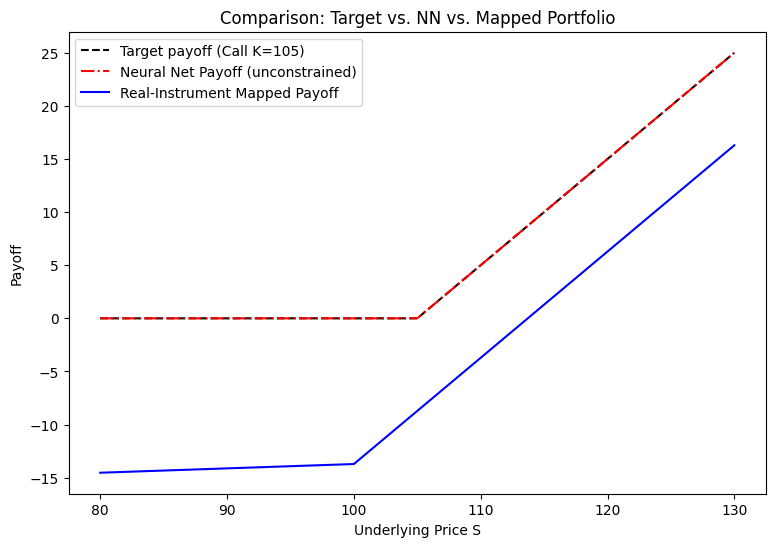

MSE( NN vs Target ) = 0.0000
MSE( Mapped vs Target ) = 130.8324

Final layer weights (W2) shape: (16, 1)
Final layer bias (b2): [-4.3348603]


In [6]:
##############################################
# 0) Market Data
##############################################
ticker_symbol   = 'NVDA'
expiration_date = '2025-01-03'
ticker = yf.Ticker(ticker_symbol)
chain = ticker.option_chain(expiration_date)
calls_df = chain.calls
puts_df  = chain.puts

##############################################
# 1) Map the hidden neurons to a real portfolio
##############################################
portfolio = map_nn_weights_to_portfolio(model_unconstr, calls_df, puts_df)
print("=== MAPPED PORTFOLIO ===")
for p in portfolio:
    print(p)

##############################################
# 2) Evaluate that portfolio on a test range
##############################################
S_test = np.linspace(80, 130, 51)  # 51 points from 80 to 130
mapped_payoffs = portfolio_to_payoff_array(portfolio, S_test)

##############################################
# 3) Compare to the original NN's payoff
##############################################
# We'll just do a direct "NN's payoff" by calling model_unconstr.predict.
X_test = S_test.reshape(-1,1).astype('float32')
nn_payoffs = model_unconstr.predict(X_test).flatten()

##############################################
# 4) Compare to the target payoff as well
##############################################
K_target = 105
target_payoff_array = np.maximum(S_test - K_target, 0)

# Visualization
plt.figure(figsize=(9,6))
plt.plot(S_test, target_payoff_array, 'k--', label='Target payoff (Call K=105)')
plt.plot(S_test, nn_payoffs, 'r-.', label='Neural Net Payoff (unconstrained)')
plt.plot(S_test, mapped_payoffs, 'b-', label='Real-Instrument Mapped Payoff')
plt.xlabel("Underlying Price S")
plt.ylabel("Payoff")
plt.title("Comparison: Target vs. NN vs. Mapped Portfolio")
plt.legend()
plt.show()

##############################################
# 5) Evaluate MSE vs. target payoff (optional)
##############################################
mse_nn = np.mean((nn_payoffs - target_payoff_array)**2)
mse_mapped = np.mean((mapped_payoffs - target_payoff_array)**2)
print(f"MSE( NN vs Target ) = {mse_nn:.4f}")
print(f"MSE( Mapped vs Target ) = {mse_mapped:.4f}")

##############################################
# 6) Inspect final-layer weights (optional)
##############################################
dense_final = model_unconstr.layers[-1]
W2, b2 = dense_final.get_weights()
print("\nFinal layer weights (W2) shape:", W2.shape)
print("Final layer bias (b2):", b2)


In [7]:
def portfolio_to_instruments_dict(portfolio):
    """
    Translate the list of {instrument, strike, units, ...} from map_nn_weights_to_portfolio
    into a list of payoff functions for build_real_instruments_model.

    We do NOT multiply by 'units' here, because the final Dense(1) layer 
    in the real-instruments model will learn (or refine) the weights.
    """
    instruments_dict = []

    for item in portfolio:
        instr_type = item['instrument']
        strike     = item['strike']

        if instr_type == 'forward':
            # A forward payoff: f(S) = S
            payoff_fn = forward_payoff(None)

        elif instr_type == 'call':
            # Real call payoff: max(S - strike, 0)
            payoff_fn = real_call_payoff(strike)

        elif instr_type == 'put':
            # Real put payoff: max(strike - S, 0)
            payoff_fn = real_put_payoff(strike)

        else:
            # skip anything else (e.g. 'dead' or unexpected)
            continue

        instruments_dict.append(payoff_fn)

    return instruments_dict


In [8]:
portfolio = map_nn_weights_to_portfolio(model_unconstr, calls_df, puts_df)


In [9]:
instruments_dict = portfolio_to_instruments_dict(portfolio)


In [10]:
class RealInstrumentsLayer(tf.keras.layers.Layer):
    """
    A custom layer that takes in S (shape=(batch_size, 1)) 
    and outputs a vector [f1(S), f2(S), ..., fL(S)] for each real instrument.
    """
    def __init__(self, instruments_dict, **kwargs):
        super().__init__(**kwargs)
        self.instruments_dict = instruments_dict

    def call(self, inputs):
        # inputs: shape (batch_size, 1)
        payoff_list = []
        for payoff_fn in self.instruments_dict:
            payoff = payoff_fn(inputs)  
            payoff = tf.reshape(payoff, [-1, 1])  # shape (batch_size,1)
            payoff_list.append(payoff)

        return tf.concat(payoff_list, axis=1)  # shape => (batch_size, L)


In [11]:
def build_real_instruments_model(instruments_dict, nonnegative=False):
    constraint = tf.keras.constraints.NonNeg() if nonnegative else None
    model = tf.keras.Sequential([
        RealInstrumentsLayer(instruments_dict=instruments_dict),
        tf.keras.layers.Dense(1, use_bias=True, activation=None,
                              kernel_constraint=constraint)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [12]:
def generate_underlying_prices(n_samples=2000, S0=100.0, mu=0.0, sigma=0.2):
    """
    Generate final prices S_T by lognormal random draws: 
      S_T = S0 * exp((mu - 0.5 * sigma^2)*T + sigma * Z)
    For T=1, mu=0, sigma=0.2 => moderate volatility around 100
    """
    Z = np.random.normal(0, 1, n_samples)
    ST = S0 * np.exp((mu - 0.5 * sigma**2) + sigma * Z)
    return ST


=== MAPPED PORTFOLIO ===
{'instrument': 'constant', 'strike': None, 'units': np.float32(-4.3348603), 'comment': 'final-layer bias'}
{'instrument': 'put', 'strike': 330.0, 'units': np.float32(-7.818682e-05), 'comment': 'hidden 3, w2=0.011, w1=-0.007, b1=4.676'}
{'instrument': 'put', 'strike': 100.0, 'units': np.float32(-0.1345895), 'comment': 'hidden 5, w2=1.604, w1=-0.084, b1=8.804'}
{'instrument': 'forward', 'strike': None, 'units': np.float32(-0.015401415), 'comment': 'hidden 7, w2=-0.644, w1=0.024, b1=7.232'}
{'instrument': 'put', 'strike': 330.0, 'units': np.float32(4.943479e-05), 'comment': 'hidden 8, w2=-0.041, w1=-0.001, b1=5.458'}
{'instrument': 'call', 'strike': 100.0, 'units': np.float32(0.8654104), 'comment': 'hidden 9, w2=5.612, w1=0.154, b1=-16.194'}
{'instrument': 'call', 'strike': 100.0, 'units': np.float32(0.08457017), 'comment': 'hidden 10, w2=0.343, w1=0.246, b1=-5.949'}
{'instrument': 'call', 'strike': 100.0, 'units': np.float32(0.14378043), 'comment': 'hidden 11, w2

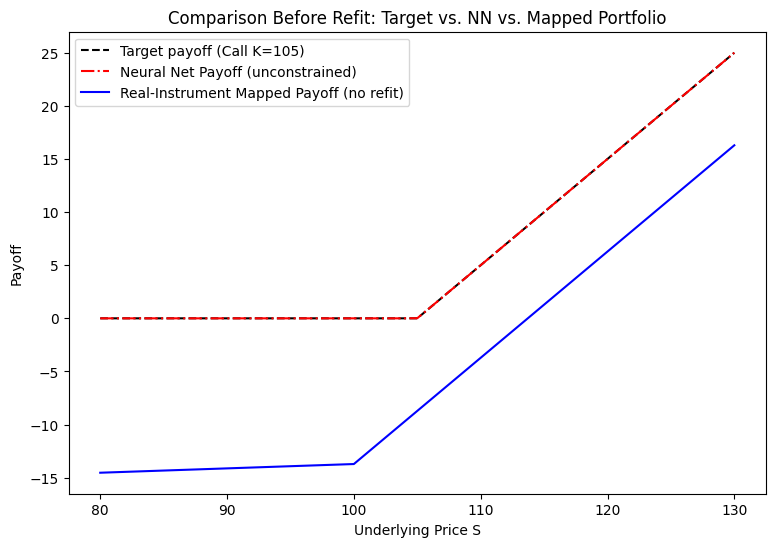

MSE( NN vs Target )         = 0.0000
MSE( Mapped vs Target )     = 130.8324

Epoch 628: early stopping
Restoring model weights from the end of the best epoch: 618.

Done re-fitting the real-instrument model.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


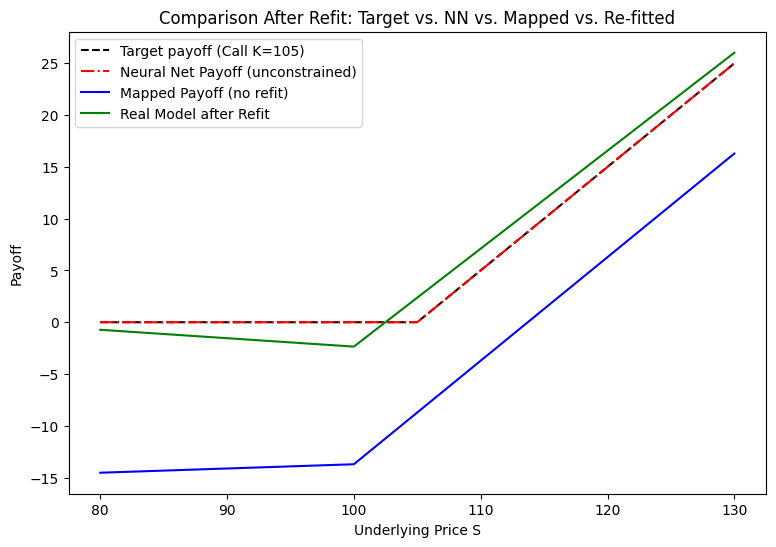

MSE( Refit vs Target ) = 2.7221

Final layer weights shape = (8, 1)
Final layer bias shape    = (1,)
Weights:
 [ 0.4776751  -0.14809872 -0.14955147 -0.41654196  0.25480387  0.32370272
  0.5966321  -0.01857606]
Bias:
 0.39814046


In [13]:
##############################################
# 0) Market Data
##############################################
ticker_symbol   = 'AAPL'
expiration_date = '2025-01-03'
ticker = yf.Ticker(ticker_symbol)
chain = ticker.option_chain(expiration_date)
calls_df = chain.calls
puts_df  = chain.puts

##############################################
# 1) Map the hidden neurons to a real portfolio
##############################################
portfolio = map_nn_weights_to_portfolio(model_unconstr, calls_df, puts_df)
print("=== MAPPED PORTFOLIO ===")
for p in portfolio:
    print(p)

##############################################
# 2) Evaluate that 'un-refitted' portfolio on a test range
##############################################
S_test = np.linspace(80, 130, 51)  # 51 points from 80 to 130
mapped_payoffs = portfolio_to_payoff_array(portfolio, S_test)

##############################################
# 3) Compare to the original NN's payoff
##############################################
X_test = S_test.reshape(-1,1).astype('float32')
nn_payoffs = model_unconstr.predict(X_test).flatten()

##############################################
# 4) Compare to the target payoff
##############################################
K_target = 105
target_payoff_array = np.maximum(S_test - K_target, 0)

# Plot before re-fitting
plt.figure(figsize=(9,6))
plt.plot(S_test, target_payoff_array, 'k--', label='Target payoff (Call K=105)')
plt.plot(S_test, nn_payoffs, 'r-.', label='Neural Net Payoff (unconstrained)')
plt.plot(S_test, mapped_payoffs, 'b-', label='Real-Instrument Mapped Payoff (no refit)')
plt.xlabel("Underlying Price S")
plt.ylabel("Payoff")
plt.title("Comparison Before Refit: Target vs. NN vs. Mapped Portfolio")
plt.legend()
plt.show()

mse_nn = np.mean((nn_payoffs - target_payoff_array)**2)
mse_mapped = np.mean((mapped_payoffs - target_payoff_array)**2)
print(f"MSE( NN vs Target )         = {mse_nn:.4f}")
print(f"MSE( Mapped vs Target )     = {mse_mapped:.4f}")

##############################################
# 5) Now Re-Fit a second model with real instruments
##############################################
# 5.1) Convert 'portfolio' -> a list of payoff_fns, ignoring the 'units'
instruments_dict = portfolio_to_instruments_dict(portfolio)

# 5.2) Build the real-instrument model
model_real = build_real_instruments_model(instruments_dict, nonnegative=False)

##############################################
# 5.3) Generate new training data
##############################################
def generate_underlying_prices(n_samples=3000, S0=100, mu=0.0, sigma=0.3):
    """
    Generate final prices S_T by lognormal random draws:
      S_T = S0 * exp((mu - 0.5*sigma^2)*1 + sigma * Z)
    """
    Z = np.random.normal(0, 1, n_samples)
    ST = S0 * np.exp((mu - 0.5*sigma**2) + sigma * Z)
    return ST

n_samples = 3000
S_data = generate_underlying_prices(n_samples, S0=100, mu=0.0, sigma=0.3)
y_data = np.maximum(S_data - K_target, 0)  # the same payoff => call at K=105

X_m = S_data.reshape(-1,1).astype('float32')
y_m = y_data.reshape(-1,1).astype('float32')

# Train/test split for validation
X_train, X_val, y_train, y_val = train_test_split(X_m, y_m, test_size=0.2, random_state=42)

# EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', mode='min',
    patience=10, restore_best_weights=True, verbose=1
)

##############################################
# 5.4) Fit the real model
##############################################
model_real.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=int(0.1 * X_train.shape[0]),
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=0
)

print("\nDone re-fitting the real-instrument model.\n")

##############################################
# 6) Evaluate the re-fitted real model
##############################################
# We'll evaluate it on S_test so we can compare lines on the same plot.
y_refit = model_real.predict(X_test).flatten()

plt.figure(figsize=(9,6))
plt.plot(S_test, target_payoff_array, 'k--', label='Target payoff (Call K=105)')
plt.plot(S_test, nn_payoffs, 'r-.', label='Neural Net Payoff (unconstrained)')
plt.plot(S_test, mapped_payoffs, 'b-', label='Mapped Payoff (no refit)')
plt.plot(S_test, y_refit, 'g-', label='Real Model after Refit')
plt.xlabel("Underlying Price S")
plt.ylabel("Payoff")
plt.title("Comparison After Refit: Target vs. NN vs. Mapped vs. Re-fitted")
plt.legend()
plt.show()

# MSE after re-fit
mse_refit = np.mean((y_refit - target_payoff_array)**2)
print(f"MSE( Refit vs Target ) = {mse_refit:.4f}")

##############################################
# 7) Inspect final layer weights
##############################################
layer_real = model_real.layers[-1]  # Dense(1)
w_final, b_final = layer_real.get_weights()
print(f"\nFinal layer weights shape = {w_final.shape}")
print(f"Final layer bias shape    = {b_final.shape}")
print("Weights:\n", w_final.flatten())
print("Bias:\n", b_final[0])


Restoring model weights from the end of the best epoch: 500.
Finished training the unconstrained RLNN on the same data.

=== MAPPED PORTFOLIO (from unconstrained net) ===
{'instrument': 'constant', 'strike': None, 'units': np.float32(-0.0019130186), 'comment': 'final-layer bias'}
{'instrument': 'call', 'strike': 100.0, 'units': np.float32(0.99946964), 'comment': 'hidden 2, w2=3.907, w1=0.256, b1=-26.855'}
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/stepWARNING:tensorflow:6 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000204572151C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retrac

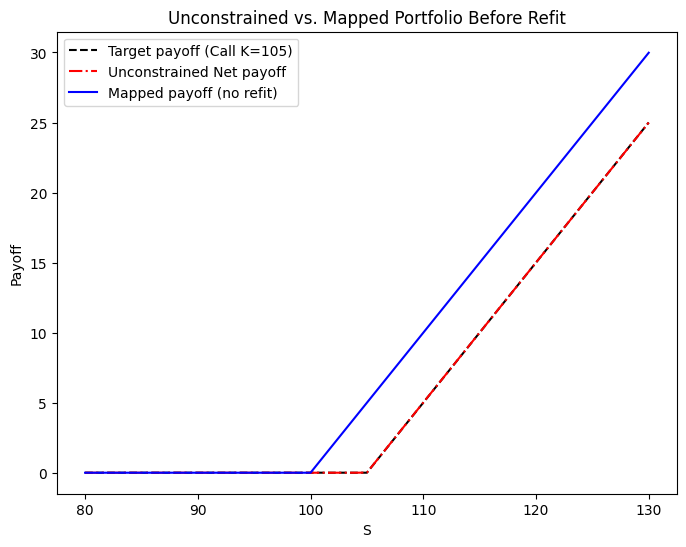

MSE( NN vs Target )      = 0.0000
MSE( Mapped vs Target )  = 13.2750

Restoring model weights from the end of the best epoch: 500.
Finished re-fitting the real-instrument model on the same data.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


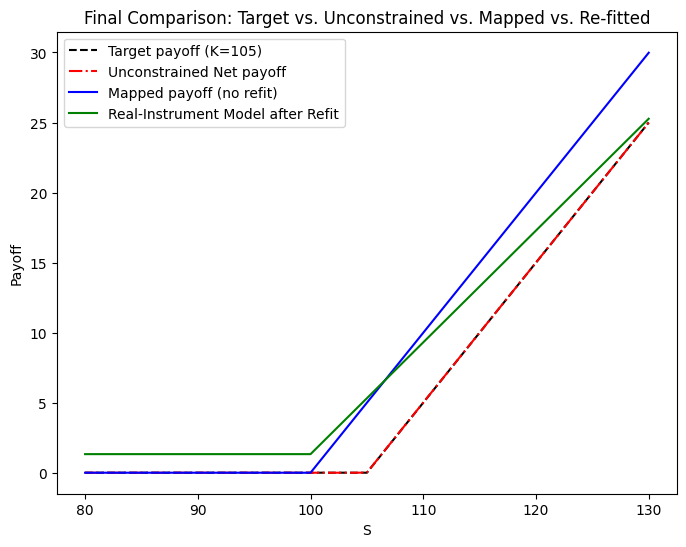

MSE( Refit vs Target ) = 6.7952

Final layer weights shape = (1, 1)
Final layer bias shape    = (1,)
Weights: [0.7981507]
Bias: 1.3251914


In [14]:
###############################################################################
# 2) Build and train "unconstrained" net

# Generate the *same data* for both unconstrained and real-instruments approach
K_TARGET = 105
S_data = generate_underlying_prices(3000, S0=100, mu=0.05, sigma=0.2)
y_data = target_call_payoff(S_data, K_TARGET)

X_all = S_data.reshape(-1,1).astype('float32')
y_all = y_data.reshape(-1,1).astype('float32')

# Train/test split
X_train_uc, X_val_uc, y_train_uc, y_val_uc = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

unconstrained_model = create_unconstrained_net(hidden_units=4, lr=0.01)

early_stopping_uc = EarlyStopping(
    monitor='val_loss', mode='min',
    patience=10, restore_best_weights=True, verbose=1
)

unconstrained_model.fit(
    X_train_uc, y_train_uc,
    epochs=500,
    batch_size=int(0.1 * X_train_uc.shape[0]),
    validation_data=(X_val_uc, y_val_uc),
    callbacks=[early_stopping_uc],
    verbose=0
)

print("Finished training the unconstrained RLNN on the same data.\n")


###############################################################################
# 3) Map NN => real portfolio
###############################################################################

# Pull real market data (AAPL example):
ticker_symbol   = 'AAPL'
expiration_date = '2025-01-03'
ticker = yf.Ticker(ticker_symbol)
chain = ticker.option_chain(expiration_date)
calls_df = chain.calls
puts_df  = chain.puts

# 3.1) Map hidden neurons => portfolio
portfolio = map_nn_weights_to_portfolio(unconstrained_model, calls_df, puts_df)
print("=== MAPPED PORTFOLIO (from unconstrained net) ===")
for p in portfolio:
    print(p)

###############################################################################
# 4) Evaluate "naive" mapped portfolio vs. unconstrained net vs. target
###############################################################################

S_test = np.linspace(80, 130, 51)
X_test_plot = S_test.reshape(-1,1).astype('float32')

mapped_payoffs_naive = portfolio_to_payoff_array(portfolio, S_test)

nn_payoffs = unconstrained_model.predict(X_test_plot).flatten()
target_payoff_vec = np.maximum(S_test - K_TARGET, 0.0)

plt.figure(figsize=(8,6))
plt.plot(S_test, target_payoff_vec, 'k--', label='Target payoff (Call K=105)')
plt.plot(S_test, nn_payoffs, 'r-.', label='Unconstrained Net payoff')
plt.plot(S_test, mapped_payoffs_naive, 'b-', label='Mapped payoff (no refit)')
plt.xlabel("S")
plt.ylabel("Payoff")
plt.title("Unconstrained vs. Mapped Portfolio Before Refit")
plt.legend()
plt.show()

mse_nn = np.mean((nn_payoffs - target_payoff_vec)**2)
mse_map = np.mean((mapped_payoffs_naive - target_payoff_vec)**2)
print(f"MSE( NN vs Target )      = {mse_nn:.4f}")
print(f"MSE( Mapped vs Target )  = {mse_map:.4f}\n")


###############################################################################
# 5) Refit a new "Real Instruments" model on the *same data*
###############################################################################

def portfolio_to_instruments_dict(portfolio):
    """
    Convert the mapped portfolio to a list of bare payoff_fns
    (ignoring 'units'), so the new model can learn the combination.
    """
    instruments_list = []
    for item in portfolio:
        instr = item['instrument']
        strike = item['strike']
        if instr == 'forward':
            payoff_fn = forward_payoff(None)
        elif instr == 'call':
            payoff_fn = real_call_payoff(strike)
        elif instr == 'put':
            payoff_fn = real_put_payoff(strike)
        else:
            continue
        instruments_list.append(payoff_fn)
    return instruments_list

instruments_dict = portfolio_to_instruments_dict(portfolio)

# Build the real-instrument model
model_real = build_real_instruments_model(instruments_dict, nonnegative=False)

# We'll re-split the *same data* (X_all, y_all) for training/validation
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

early_stopping_r = EarlyStopping(
    monitor='val_loss', mode='min',
    patience=10, restore_best_weights=True, verbose=1
)

model_real.fit(
    X_train_r, y_train_r,
    epochs=500,
    batch_size=int(0.1 * X_train_r.shape[0]),
    validation_data=(X_val_r, y_val_r),
    callbacks=[early_stopping_r],
    verbose=0
)

print("Finished re-fitting the real-instrument model on the same data.\n")


###############################################################################
# 6) Evaluate the re-fitted real model
###############################################################################

y_refit = model_real.predict(X_test_plot).flatten()

plt.figure(figsize=(8,6))
plt.plot(S_test, target_payoff_vec, 'k--', label='Target payoff (K=105)')
plt.plot(S_test, nn_payoffs, 'r-.', label='Unconstrained Net payoff')
plt.plot(S_test, mapped_payoffs_naive, 'b-', label='Mapped payoff (no refit)')
plt.plot(S_test, y_refit, 'g-', label='Real-Instrument Model after Refit')
plt.xlabel("S")
plt.ylabel("Payoff")
plt.title("Final Comparison: Target vs. Unconstrained vs. Mapped vs. Re-fitted")
plt.legend()
plt.show()

mse_refit = np.mean((y_refit - target_payoff_vec)**2)
print(f"MSE( Refit vs Target ) = {mse_refit:.4f}\n")

# Inspect final layer weights
dense_final = model_real.layers[-1]
w_final, b_final = dense_final.get_weights()
print("Final layer weights shape =", w_final.shape)
print("Final layer bias shape    =", b_final.shape)
print("Weights:", w_final.flatten())
print("Bias:", b_final[0])


Epoch 327: early stopping
Restoring model weights from the end of the best epoch: 317.
Finished training the unconstrained RLNN on the same data.

=== MAPPED PORTFOLIO (from unconstrained net) ===
{'instrument': 'constant', 'strike': None, 'units': np.float32(9.403119), 'comment': 'final-layer bias'}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


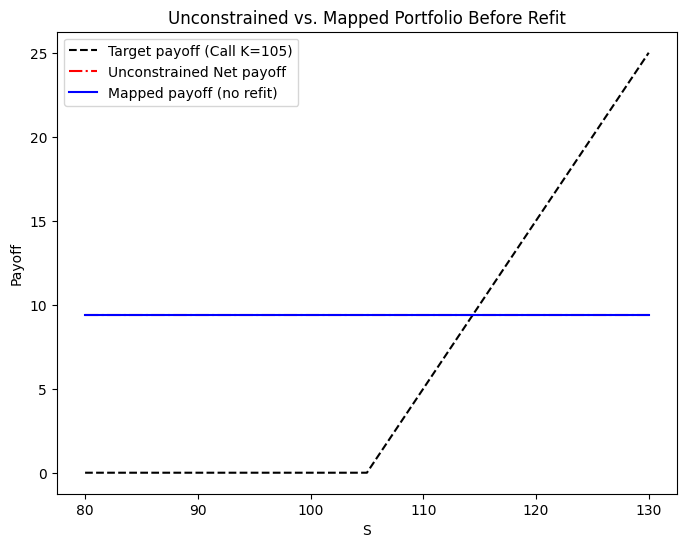

MSE( NN vs Target )      = 76.9083
MSE( Mapped vs Target )  = 76.9083

Total candidate instruments: 3
LP Minimax solution, E = 3.5714286
alpha_sol shape: (3,)
Alpha solution snippet: [0.         0.71428571 0.        ] ...
Selected 1 instruments after pruning with threshold=0.0001
Restoring model weights from the end of the best epoch: 500.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


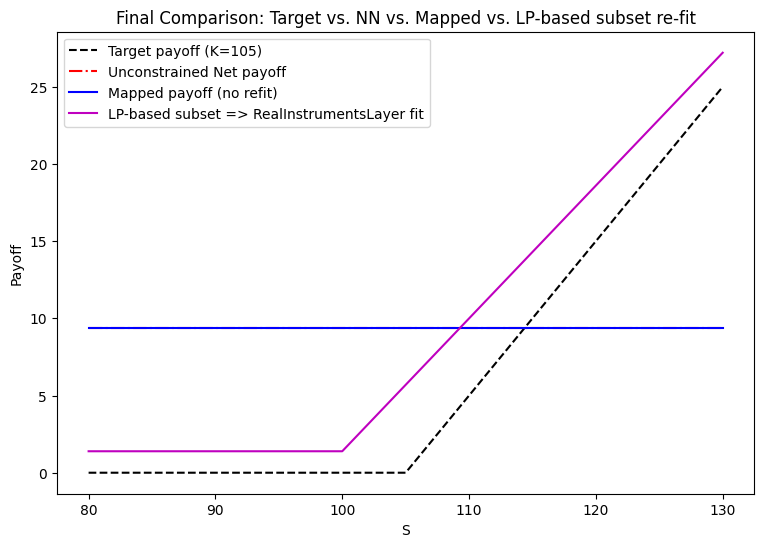

MSE( LP-based subset re-fit vs Target ) = 10.3684



In [ ]:

###############################################################################
# 1) Build and train "unconstrained" net
###############################################################################

K_TARGET = 105
S_data = generate_underlying_prices(3000, S0=100, mu=0.0, sigma=0.3)
y_data = target_call_payoff(S_data, K_TARGET)

X_all = S_data.reshape(-1,1).astype('float32')
y_all = y_data.reshape(-1,1).astype('float32')

# Train/test split
X_train_uc, X_val_uc, y_train_uc, y_val_uc = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

unconstrained_model = create_unconstrained_net(hidden_units=4, lr=0.01)

early_stopping_uc = EarlyStopping(
    monitor='val_loss', mode='min',
    patience=10, restore_best_weights=True, verbose=1
)

unconstrained_model.fit(
    X_train_uc, y_train_uc,
    epochs=500,
    batch_size=int(0.1 * X_train_uc.shape[0]),
    validation_data=(X_val_uc, y_val_uc),
    callbacks=[early_stopping_uc],
    verbose=0
)

print("Finished training the unconstrained RLNN on the same data.\n")

###############################################################################
# 2) Real market data, map hidden neurons => portfolio
###############################################################################
ticker_symbol   = 'AAPL'
expiration_date = '2025-01-03'
ticker = yf.Ticker(ticker_symbol)
chain = ticker.option_chain(expiration_date)
calls_df = chain.calls
puts_df  = chain.puts

portfolio = map_nn_weights_to_portfolio(unconstrained_model, calls_df, puts_df)
print("=== MAPPED PORTFOLIO (from unconstrained net) ===")
for p in portfolio:
    print(p)

###############################################################################
# 4) Evaluate "naive" mapped portfolio vs. unconstrained net vs. target
###############################################################################
S_test = np.linspace(80, 130, 51)
X_test_plot = S_test.reshape(-1,1).astype('float32')

mapped_payoffs_naive = portfolio_to_payoff_array(portfolio, S_test)
nn_payoffs = unconstrained_model.predict(X_test_plot).flatten()
target_payoff_vec = np.maximum(S_test - K_TARGET, 0.0)

plt.figure(figsize=(8,6))
plt.plot(S_test, target_payoff_vec, 'k--', label='Target payoff (Call K=105)')
plt.plot(S_test, nn_payoffs, 'r-.', label='Unconstrained Net payoff')
plt.plot(S_test, mapped_payoffs_naive, 'b-', label='Mapped payoff (no refit)')
plt.xlabel("S")
plt.ylabel("Payoff")
plt.title("Unconstrained vs. Mapped Portfolio Before Refit")
plt.legend()
plt.show()

mse_nn = np.mean((nn_payoffs - target_payoff_vec)**2)
mse_map = np.mean((mapped_payoffs_naive - target_payoff_vec)**2)
print(f"MSE( NN vs Target )      = {mse_nn:.4f}")
print(f"MSE( Mapped vs Target )  = {mse_map:.4f}\n")

###############################################################################
# 5) LP Step: Build big dictionary of real instruments, replicate payoff
###############################################################################
def build_instrument_payoff_matrix(instrument_list, S_values):
    """
    instrument_list: e.g. [('forward', None), ('call', 100.0), ('put', 95.0), ...]
    S_values: array shape (N,). We'll build matrix shape (N, L).
    """
    N = len(S_values)
    L = len(instrument_list)
    payoff_matrix = np.zeros((N,L), dtype=float)

    for j, (typ, strike) in enumerate(instrument_list):
        if typ == 'forward':
            payoff_fn = forward_payoff(None)
        elif typ == 'call':
            payoff_fn = real_call_payoff(strike)
        elif typ == 'put':
            payoff_fn = real_put_payoff(strike)
        else:
            # skip unknown
            def payoff_fn(S):
                return tf.zeros_like(S[:,0])

        S_tensor = tf.convert_to_tensor(S_values.reshape(-1,1), dtype=tf.float32)
        p = payoff_fn(S_tensor).numpy().flatten()
        payoff_matrix[:,j] = p

    return payoff_matrix

def solve_lp_minimax(payoff_matrix, target_payoff, alpha_nonneg=True):
    """
    Minimally-viable L-infinity approach:
      min E s.t. for all i:
         -E <= sum_j alpha_j * payoff_matrix[i,j] - target_payoff[i] <= E,
    If alpha_nonneg=True => alpha_j >= 0
    """
    from pulp import LpProblem, LpMinimize, LpVariable

    N, L = payoff_matrix.shape
    prob = LpProblem("replicate_payoff", LpMinimize)

    alpha_vars = []
    for j in range(L):
        if alpha_nonneg:
            alpha_vars.append(LpVariable(f"alpha_{j}", lowBound=0))
        else:
            alpha_vars.append(LpVariable(f"alpha_{j}", lowBound=None))

    E = LpVariable("E", lowBound=0)

    # Objective
    prob += E

    for i in range(N):
        row_sum = None
        for j in range(L):
            row_sum = alpha_vars[j]*payoff_matrix[i,j] if row_sum is None else row_sum + alpha_vars[j]*payoff_matrix[i,j]
        # row_sum - target_payoff[i] <= E
        prob += row_sum - target_payoff[i] <= E
        # -(row_sum - target_payoff[i]) <= E => target_payoff[i] - row_sum <= E
        prob += target_payoff[i] - row_sum <= E

    prob.solve(pulp.PULP_CBC_CMD(msg=0))

    alpha_sol = np.array([v.varValue for v in alpha_vars])
    E_sol = E.varValue
    return alpha_sol, E_sol

# 5.1) Build a big dictionary from calls_df, puts_df (plus forward)
all_instruments = []
# Forward
all_instruments.append(('forward', None))

# Let's pick calls with strike from e.g. 90 to 115
for idx, row in calls_df.iterrows():
    strike = float(row['strike'])
    if 90 <= strike <= 115:
        all_instruments.append(('call', strike))

# Similarly pick puts from e.g. 90 to 115
for idx, row in puts_df.iterrows():
    strike = float(row['strike'])
    if 90 <= strike <= 115:
        all_instruments.append(('put', strike))

print(f"Total candidate instruments: {len(all_instruments)}")

# 5.2) Build payoff matrix for S_test, solve LP to replicate target payoff
payoff_mat_lp = build_instrument_payoff_matrix(all_instruments, S_test)
alpha_sol, E_sol = solve_lp_minimax(payoff_mat_lp, target_payoff_vec, alpha_nonneg=True)

print("LP Minimax solution, E =", E_sol)
print("alpha_sol shape:", alpha_sol.shape)
print("Alpha solution snippet:", alpha_sol[:10], "...")

# 5.3) Prune small weights
threshold = 1e-4
selected_instruments = []
for (typ, strike), alpha_val in zip(all_instruments, alpha_sol):
    if alpha_val > threshold:
        selected_instruments.append((typ, strike))

print(f"Selected {len(selected_instruments)} instruments after pruning with threshold={threshold}")

###############################################################################
# 6) Build RealInstrumentsLayer with selected instruments, re-fit
###############################################################################
def build_instruments_dict_from_tuples(instrument_tuples):
    """
    Convert a list of (type, strike) into a list of payoff_fns
    """
    instruments_list = []
    for (typ, strike) in instrument_tuples:
        if typ == 'forward':
            payoff_fn = forward_payoff(None)
        elif typ == 'call':
            payoff_fn = real_call_payoff(strike)
        elif typ == 'put':
            payoff_fn = real_put_payoff(strike)
        else:
            # skip unknown
            payoff_fn = None
        if payoff_fn is not None:
            instruments_list.append(payoff_fn)
    return instruments_list

# Build RealInstrumentsLayer-based model
model_lp = build_real_instruments_model(
    build_instruments_dict_from_tuples(selected_instruments),
    nonnegative=False
)

# Same data split
X_train_lp, X_val_lp, y_train_lp, y_val_lp = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

early_stopping_lp = EarlyStopping(monitor='val_loss', mode='min',
                                  patience=10, restore_best_weights=True, verbose=1)

model_lp.fit(
    X_train_lp, y_train_lp,
    epochs=500,
    batch_size=int(0.1 * X_train_lp.shape[0]),
    validation_data=(X_val_lp, y_val_lp),
    callbacks=[early_stopping_lp],
    verbose=0
)

###############################################################################
# 7) Evaluate final payoff from LP-based model
###############################################################################
y_lp_refit = model_lp.predict(X_test_plot).flatten()

plt.figure(figsize=(9,6))
plt.plot(S_test, target_payoff_vec, 'k--', label='Target payoff (K=105)')
plt.plot(S_test, nn_payoffs, 'r-.', label='Unconstrained Net payoff')
plt.plot(S_test, mapped_payoffs_naive, 'b-', label='Mapped payoff (no refit)')

# Suppose from earlier re-fit step you also had model_real
# We'll just show y_lp_refit
plt.plot(S_test, y_lp_refit, 'm-', label='LP-based subset => RealInstrumentsLayer fit')
plt.xlabel("S")
plt.ylabel("Payoff")
plt.title("Final Comparison: Target vs. NN vs. Mapped vs. LP-based subset re-fit")
plt.legend()
plt.show()

mse_lp_refit = np.mean((y_lp_refit - target_payoff_vec)**2)
print(f"MSE( LP-based subset re-fit vs Target ) = {mse_lp_refit:.4f}\n")
